# Example of usage ImageAdaptiveThresholding and  ImageAdaptiveBinarizer transformers

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version.\spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
#or install from local path
#%pip install ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

Processing /Users/nmelnik/IdeaProjects/spark-ocr/python/dist/spark-ocr-3.0.0.spark30.tar.gz
  Created wheel for spark-ocr: filename=spark_ocr-3.0.0.spark30-py3-none-any.whl size=8089825 sha256=321fb400bdaa1308b2cb446b318d981181709639b62adc098bf8a6a05728cc14
  Stored in directory: /Users/nmelnik/Library/Caches/pip/wheels/21/3a/34/388c861faba29ad5d6c5aad555ec1411755e78b8f5cecdb10d
Successfully built spark-ocr
  Attempting uninstall: spark-ocr
    Found existing installation: spark-ocr 3.0.0.spark30
    Uninstalling spark-ocr-3.0.0.spark30:
      Successfully uninstalled spark-ocr-3.0.0.spark30
You should consider upgrading via the '/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [ ]:
from sparkocr import info
info()

In [ ]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

## Import OCR transformers

In [5]:
from pyspark.ml import PipelineModel

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image

## Define OCR transformers and pipeline

In [6]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

ocr = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL)

## Read PDF document as binary file

In [7]:
import pkg_resources
image_example = "data/images/text_with_noise.png"
image_example_df = spark.read.format("binaryFile").load(image_example).cache()

## Gaussian local tresholding

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


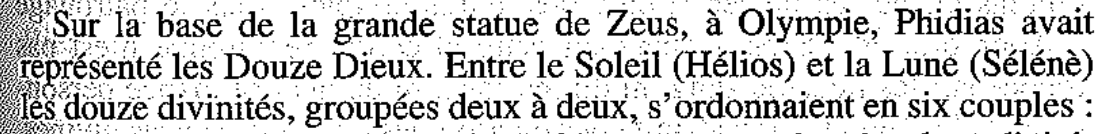

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 12


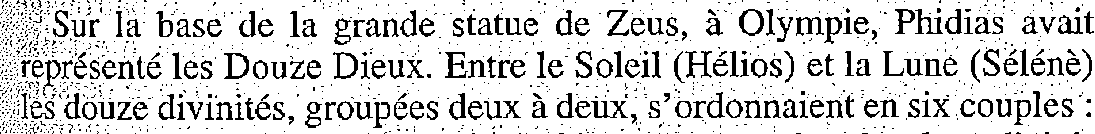

Detected text:

Su la base” de la grande statue de Zeus, a “Olympie, Phidias avait
nté les Douze Dieux. ‘Entre le’ Soleil (Hélios) et Ja Lune (Séléné)
Ze divinités, groupées deux a deux, Js "ordonnaient en six couples’:
  
 


In [8]:
adaptive_thresholding = ImageAdaptiveThresholding() \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setBlockSize(35) \
    .setOffset(90) \
    .setKeepInput(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_thresholding,
    ocr
])

for r in pipeline.transform(image_example_df).select("image", "corrected_image", "text").collect():
    display_image(r.image)
    display_image(r.corrected_image)
    print(f"Detected text:\n{r.text}")

## Sauvola tresholding

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


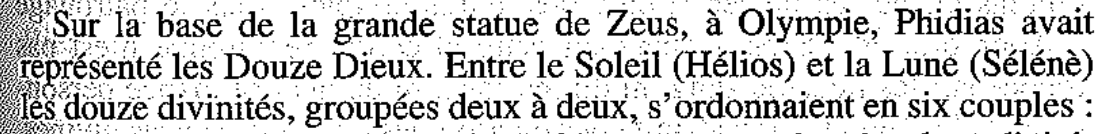

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 12


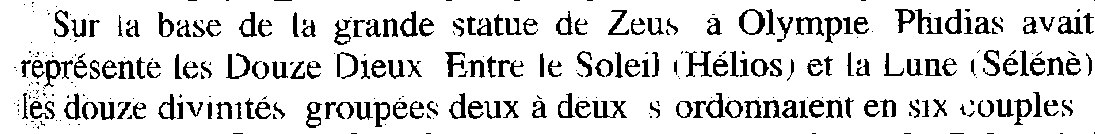

Detected text:

“Sur la base de la grande statue de Zeus a Olympie Phidias avait
représente les Douze Dieux Entre le Solei) (Hélios) et la Lune (Séléné)
‘les douze divinités groupées deux a deux s ordonnaient en six couples


In [9]:
adaptive_binarization = ImageAdaptiveBinarizer()
adaptive_binarization.setInputCol("image")
adaptive_binarization.setOutputCol("corrected_image")
adaptive_binarization.setWidth(20)
adaptive_binarization.setScale(3.5)
adaptive_binarization.setMethod(TresholdingMethod.SAUVOLA)

pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_binarization,
    ocr
])

for r in pipeline.transform(image_example_df).select("image", "corrected_image", "text").collect():
    display_image(r.image)
    display_image(r.corrected_image)
    print(f"Detected text:\n{r.text}")

## Gaussian local tresholding (Scala implementation)

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


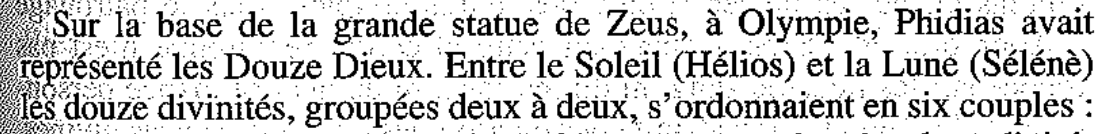

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 12


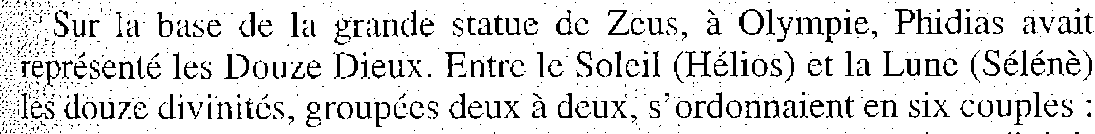

Detected text:

Sur la base de la grande statue de Zeus, 4 Olympic, Phidias avait
résenlé les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Séléné)
ouze diviniiés, groupées deux 4 deux, s’ordonnaient en six couples :
   


In [10]:
adaptive_binarization = ImageAdaptiveBinarizer()
adaptive_binarization.setInputCol("image")
adaptive_binarization.setOutputCol("corrected_image")
adaptive_binarization.setWidth(20)
adaptive_binarization.setScale(4)
adaptive_binarization.setMethod(TresholdingMethod.GAUSSIAN)

pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_binarization,
    ocr
])

for r in pipeline.transform(image_example_df).select("image", "corrected_image", "text").collect():
    display_image(r.image)
    display_image(r.corrected_image)
    print(f"Detected text:\n{r.text}")

## Otsu thresholding

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


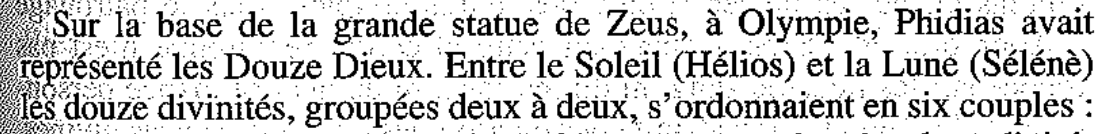

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 12


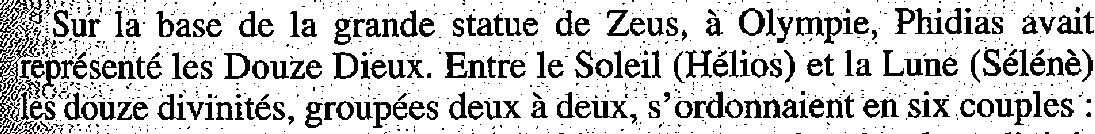

Detected text:

la base de la grande statue de Zeus, a “Olympie, Phidias avait
é les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Séléné)
ze divinités, groupées deux a deux, Ss *ordonnaient en six couples’:
  
  


In [11]:
adaptive_binarization = ImageAdaptiveBinarizer()
adaptive_binarization.setInputCol("image")
adaptive_binarization.setOutputCol("corrected_image")
adaptive_binarization.setMethod(TresholdingMethod.OTSU)


pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_binarization,
    ocr
])

for r in pipeline.transform(image_example_df).select("image", "corrected_image", "text").collect():
    display_image(r.image)
    display_image(r.corrected_image)
    print(f"Detected text:\n{r.text}")